# Download and process the Bay Area's street network
### for BPR coefficients calculation

In [1]:
import time
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox, networkx as nx

ox.config(use_cache=True, log_console=True)
print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.7.3
nx 2.2rc1.dev_20180314152658


In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

## Download and extract the counties shapefile if it doesn't already exist, then load it

To use OSMnx, we need a polygon of the Bay Area's nine counties. So, we'll download a shapefile from the census, extract our counties, and take the union to form a polygon. Also, project the polygon so we can calculate its area for density stats.

In [3]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [4]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [5]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

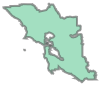

In [6]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [7]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon_hull = bayarea_polygon.convex_hull
bayarea_polygon_hull_proj, crs = ox.project_geometry(bayarea_polygon_hull)

In [8]:
# project by a mile to get connectivities surrounding our O-Ds
bayarea_polygon_hull_proj_buff = bayarea_polygon_hull_proj.buffer(1600) #1 mile in meters
bayarea_polygon_hull_buff, crs = ox.project_geometry(bayarea_polygon_hull_proj_buff, crs=crs, to_latlong=True)

## Download the street network

Now we've got our polygon of the buffered convex hull around the nine county bay area. Use OSMnx to download the street network (drivable roads).

In [9]:
# do not simplify yet, we'll strip out unwanted local streets before simplification
G = ox.graph_from_polygon(bayarea_polygon_hull_buff, network_type='drive', simplify=False)

In [10]:
print(len(G.nodes()))
print(len(G.edges()))

1221153
2337727


## Simplify and save the full street network

In [11]:
# retain only largest STRONGLY connected component
G_full = G.copy()
G_full = ox.remove_isolated_nodes(G_full)
G_full_connected = ox.get_largest_component(G_full, strongly=True)

In [12]:
# simplify the graph
G_full_simp = ox.simplify_graph(G_full_connected, strict=True)

In [13]:
# create a unique ID for each edge because osmid can hold multiple values due to topology simplification
i = 0
for u, v, k, d in G_full_simp.edges(data=True, keys=True):
    d['uniqueid'] = i
    i += 1

#### See some descriptive stats then save to disk

In [14]:
print(len(G_full_simp.nodes()))
print(len(G_full_simp.edges()))

223328
547697


In [15]:
# see some basic network stats
# note, areas/densities include water
pd.Series(ox.basic_stats(G_full_simp, area=bayarea_polygon_hull_proj_buff.area))

circuity_avg                                                               1.11151
clean_intersection_count                                                      None
clean_intersection_density_km                                                 None
edge_density_km                                                            3341.49
edge_length_avg                                                            174.016
edge_length_total                                                      9.53078e+07
intersection_count                                                          167978
intersection_density_km                                                    5.88931
k_avg                                                                      4.90487
m                                                                           547697
n                                                                           223328
node_density_km                                                            7.82988
self

In [17]:
# save nodes and edges list as csv
nodes, edges = ox.graph_to_gdfs(G_full_simp, node_geometry=False, fill_edge_geometry=False)

ecols = ['uniqueid', 'u', 'v', 'key', 'oneway', 'highway', 'name', 'length',
         'lanes', 'width', 'est_width', 'maxspeed', 'access', 'service',
         'bridge', 'tunnel', 'area', 'junction', 'osmid', 'ref']

edges = edges.drop(columns=['geometry']).reindex(columns=ecols)
nodes = nodes.reindex(columns=['osmid', 'x', 'y', 'ref', 'highway'])

nodes.to_csv('data/full_network_strongly/bay_area_full_strongly_nodes.csv', index=False, encoding='utf-8')
edges.to_csv('data/full_network_strongly/bay_area_full_strongly_edges.csv', index=False, encoding='utf-8')

In [18]:
# save as graphml for re-using later
ox.save_graphml(G_full_simp, filename='bayarea_full_simplified_strongly.graphml', folder='data/full_network_strongly')

In [19]:
# save as shapefile for GIS
ox.save_graph_shapefile(G_full_simp, filename='bayarea_full_simplified_strongly', folder='data/full_network_strongly')

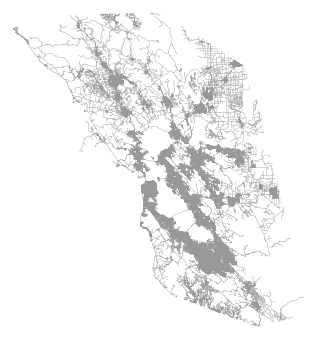

In [20]:
# visualize the network
fig, ax = ox.plot_graph(G_full_simp, node_size=0, edge_linewidth=0.2)